## Load number densities from sims.

In [9]:
from shared.preface import *
import shared.functions as fct

SIM_TYPE = 'DMONLY/SigmaConstant00'

# Initialize parameters and files.
PRE_BOX = PRE(
    sim='L025N752', 
    z0_snap=36, z4_snap=13, DM_lim=1000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100,
    pre_CPUs=128, sim_CPUs=128, mem_lim_GB=224
)

Testing=False
if Testing:
    mass_gauge = 12.0
    mass_range = 0.6
    size = 1
else:
    mass_gauge = 12.0
    mass_range = 0.6
    size = 1

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE_BOX.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE_BOX.SIM_DIR, PRE_BOX.OUT_DIR
)
halo_batch_IDs = np.load(f'{PRE_BOX.OUT_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{PRE_BOX.OUT_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

etas_arr = []
for halo_j in range(halo_num)[::-1]:

    # Load number densities.
    tot_name = f'{hname}_halo{halo_j}'
    fname = f'{PRE_BOX.NUS}nus_{tot_name}'
    out_file = f'{PRE_BOX.OUT_DIR}/number_densities_band_{fname}.npy'
    etas = np.load(f'{out_file}')/N0
    etas_arr.append(etas)

etas_sim = np.array(etas_arr).reshape(halo_num, len(NU_MRANGE))

********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: L025N752
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 128/128
DM limit for cells: 1000
# File management:
Box files directory: 
 /projects/0/einf180/Tango_sims/L025N752/DMONLY/SigmaConstant00
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/L025N752/DMONLY/SigmaConstant00
**********************************************************
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[253.5523526   12.24058042   6.9286026 ]]
***********************************


In [ ]:
from shared.preface import *
import shared.functions as fct

# Load data for MW halo only of smooth simulation.
PRE_SMOOTH = PRE(
    sim='LinfNinf', phis=10, thetas=10, vels=100,
    sim_CPUs=128, MW_HALO=True, VC_HALO=False
)

smooth_name = f'{PRE_SMOOTH.NUS}nus_smooth_{PRE_SMOOTH.HALOS}_{SOLVER}'
smooth_dir = f'{os.getcwd()}/{PRE_SMOOTH.SIM}'
u_all_MW = fct.load_sim_data(smooth_dir, smooth_name, 'velocities')

smooth_output = f'{smooth_dir}/number_densities_{smooth_name}.npy'
fct.number_densities_mass_range(
    u_all_MW, NU_MRANGE, smooth_output, 
    average=False, m_start=0.01, z_start=0.5
)
etas_smooth = np.load(f'{smooth_output}')/N0

********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: LinfNinf
Sim CPUs 128
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/LinfNinf
Halos in smooth sim: MW
**********************************************************


## Plotting.

### Local overdensity percentile band.

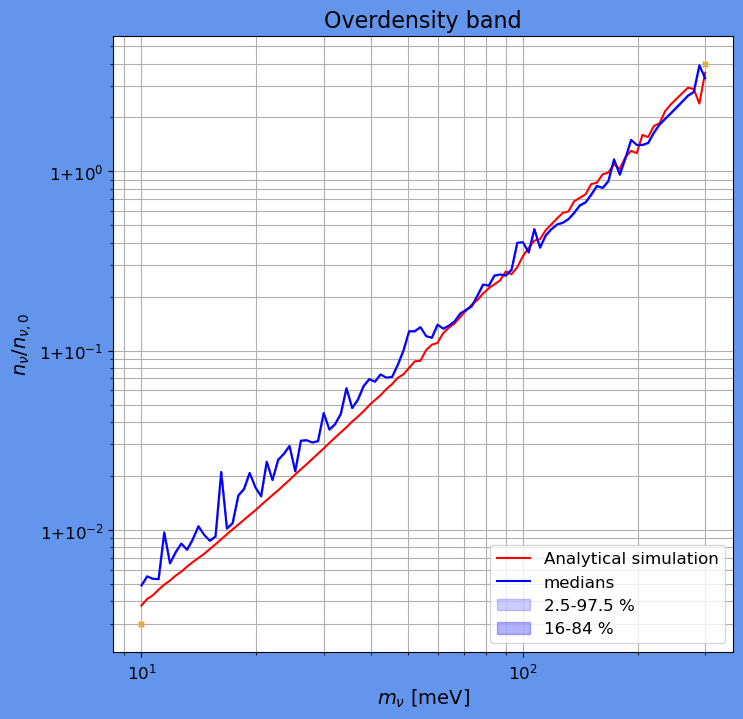

In [ ]:
fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{hname}'
fct.plot_eta_band(etas_sim, etas_smooth, NU_MRANGE, fig_dir, fname, show=True, Mertsch=True)

### Redshift evolution of local overdensity.

In [ ]:
fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{hname}'
fct.plot_eta_z_back_1Halo(u_all, NU_MASSES, fig_dir, fname, show=True)


### Phase-space distribution of neutrinos today.

In [ ]:
fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{hname}'
fct.plot_phase_space_1Halo(
    u_all, NU_MASSES, halo_batch_params[0], 
    PRE_BOX.Vs, PRE_BOX.PHIs, PRE_BOX.THETAs, PRE_BOX.LOWER, PRE_BOX.UPPER,
    fig_dir, fname, show=True
)

### Number density integral (visual for how median of momenta increases).

In [ ]:
PRE = PRE_BOX
# PRE = PRE_SMOOTH

fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fname = f'{splits[0]}_{splits[1]}_{hname}'
fct.plot_number_density_integral(
    u_all, NU_MASSES, 
    PRE.Vs, PRE.PHIs, PRE.THETAs, PRE.LOWER, PRE.UPPER,
    fig_dir, fname, show=True
)

### Redshift evolution of neutrino velocities and distances.

In [ ]:
def plot_velocities_and_distances(
    out_dir, fname, Rvir, fig_dir, fig_name, batches=False, show=False
):

    # Load positions and velocities.
    vel = fct.load_sim_data(out_dir, fname, 'velocities')
    pos = fct.load_sim_data(out_dir, fname, 'positions')

    # Magnitudes of velocities and radial distances from halo center.
    mag = np.sqrt(np.sum(vel**2, axis=2))
    dis = np.sqrt(np.sum(pos**2, axis=2))

    # Sort arrays from low to high velocity neutrinos.
    ids = mag[:,0].argsort()
    ids_2D = np.repeat(np.expand_dims(ids, axis=1), mag.shape[1], axis=1)
    u_unit = (kpc/s)/(km/s)
    mag_sort = np.take_along_axis(mag, ids_2D, axis=0)*u_unit
    dis_sort = np.take_along_axis(dis, ids_2D, axis=0)

    # Special velocity markers.
    v_start = mag_sort[:,0]
    v_max = v_start.max()
    v_esc = mag_sort[np.where(v_start <= 550)]

    # Velocity batches.
    v1 = mag_sort[np.where(v_start <= v_max/4)]
    v2 = mag_sort[np.where((v_max/4 < v_start) & (v_start <= v_max/2))]
    v3 = mag_sort[np.where((v_max/2 < v_start) & (v_start <= v_max*3/4))]
    v4 = mag_sort[np.where(v_max*3/4 < v_start)]

    # Corresponding distance batches.
    d1 = dis_sort[:len(v1),:]
    d2 = dis_sort[len(v1):len(v1)+len(v2),:]
    d3 = dis_sort[len(v1)+len(v2):len(v1)+len(v2)+len(v3),:]
    d4 = dis_sort[len(v1)+len(v2)+len(v3):,:]
    # d_esc = dis_sort[:v_esc.shape[0],:]


    # Plotting.
    fig, ax = plt.subplots(1,1)

    if batches:
        for i, d in enumerate((d1,d2,d3,d4)):
            print(d.shape, d[0,0], d[0,-1])
            y_vals = np.median(d, axis=0)
            ax.semilogy(ZEDS, y_vals, alpha=0.7, label=f'batch {i} mean')
    else:
        d_show = dis_sort[:3000,:][::300]   #! lowest velocities
        # d_show = dis_sort[3000:,:][::1000]  #! highest velocities
        for d in d_show:
            ax.semilogy(ZEDS, d)

    ax.axhline(Rvir, c='r', ls=':', label='R_vir of halo')
    # ax[j].set_xlim(-0.01,1)
    ax.legend()
    ax.set_ylabel('distance to halo center (kpc)')
    ax.set_xlabel('redshift')

    fig_out = f'{fig_dir}/distance_from_origin_{fig_name}.pdf'
    plt.savefig(
        fig_out, facecolor=fig.get_facecolor(), edgecolor='none', 
        bbox_inches='tight'
    )
    if show:
        plt.show()
    else:
        plt.close()



# Discrete simulation.
halo_j = 0
tot_name = f'{hname}_halo{halo_j}'
fname = f'{PRE_BOX.NUS}nus_{tot_name}'
Rvir = halo_batch_params[halo_j, 0]

fig_dir = f'{os.getcwd()}/figures'
splits = re.split('/', SIM_TYPE)
fig_name = f'{splits[0]}_{splits[1]}_{hname}'

plot_velocities_and_distances(PRE_BOX.OUT_DIR, fname, Rvir, fig_dir, fig_name, batches=False, show=True)


# Smooth simulation.
# nus = 10000
# MW_HALO = True
# VC_HALO = False
# AG_HALO = False
# halos = 'MW'*MW_HALO + '+VC'*VC_HALO + '+AG'*AG_HALO

# sim = 'LinfNinf'
# fname = f'nus_{nus}_halos_{halos}_{SOLVER}'

# fig_dir = f'{os.getcwd()}/figures'

# plot_velocities_and_distances(
#     PRE_SMOOTH.OUT_DIR, fname, Rvir, fig_dir, fig_name, 
#     batches=False, show=True
# )